<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px; color:#fff;" align="center">Implement a scoring model - P7</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h3 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">| Modeling Notebook |</h3>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h4 style="width: 100%; text-align: center; float: left; font-size: 24px; color:#fff;" align="center">Data Scientist course - OpenClassrooms</h4>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries</h2>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries</h3>
</div>

In [22]:
## General
import re
import pandas as pd
import numpy as np

## Scikit Learn library
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, HalvingGridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (precision_score, roc_auc_score, recall_score, 
                             f1_score, fbeta_score, confusion_matrix, roc_curve, 
                             PrecisionRecallDisplay, ConfusionMatrixDisplay)

## imbalanced-learn
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

## LightGBM
from lightgbm import LGBMClassifier

## To use S3 files
#import boto3
#from sagemaker import get_execution_role

## Own specific functions 
from functions import *

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h2>
</div>

<div class="alert alert-block alert-info">
    <p>Definning S3 parameters
   </p>
</div>

connexion = boto3.client('s3')

bucket = "oc-data-scientist"
subfolder = "oc-p7/datasets/finals_datasets"
data_key = "df_current_clients.csv"

role = get_execution_role()
conn = boto3.client('s3')

contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

data_location = "s3://{}/{}/{}".format(bucket, subfolder, data_key)

<div class="alert alert-block alert-info">
    <p>Let's load the current clients
   </p>
</div>

df_current_clients = pd.read_csv(data_location)

In [2]:
df_current_clients = pd.read_csv(r"datasets\finals_datasets\df_current_clients.csv")

In [3]:
df_analysis(df_current_clients, "df_current_clients", analysis_type="header")


Analysis Header of df_current_clients dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 1.2 GB


<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <p>First of all, let's treat the memory to optimize its usage.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">3. Optimizing memory usage</h2>
</div>

<div class="alert alert-block alert-warning">
    <p>We should optimize the memory usage to avoid problems during executions</p>
</div>

In [4]:
df_current_clients = memory_optimization(df_current_clients)

In [5]:
df_analysis(df_current_clients, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 307507 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 459.8 MB


<div class="alert alert-block alert-success">
    <p><b>Observations / Conclusions</b></p>
    <p>The memory usage has been reduced.</p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">4. Analyzing target variable</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to analyze the target variable to see whether is an imbalanced class
   </p>
</div>

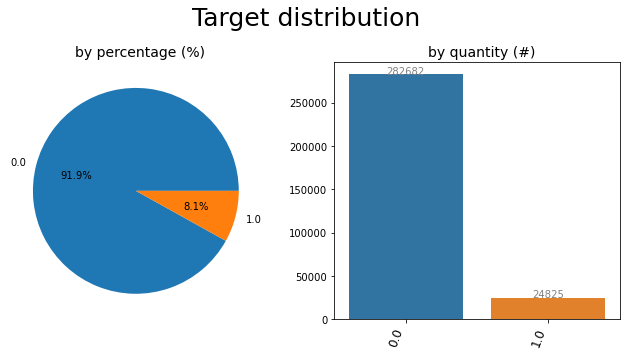

In [6]:
barplot_and_pie(df_current_clients["TARGET"], "Target distribution", " ")

<div class="alert alert-block alert-warning">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>Here we can see how much the dataset is imbalanced so, we are facing a imbalanced classification problem</li>
        <li>It is easily identifying that there are <b>loans that were repaid (0)</b> in comparison of <b>loans that were not repaid (1)</b>s</li>
        <li>We are going to treat the imbalanced class into a pipeline during the modeling</li>
    </ul> 
</div>

<div class="alert alert-block alert-danger">
    <p><b>FLAG</b>
   </p>
</div>

In [7]:
df_copy = df_current_clients.copy()

In [8]:
df_copy = df_copy.sample(frac=0.2)

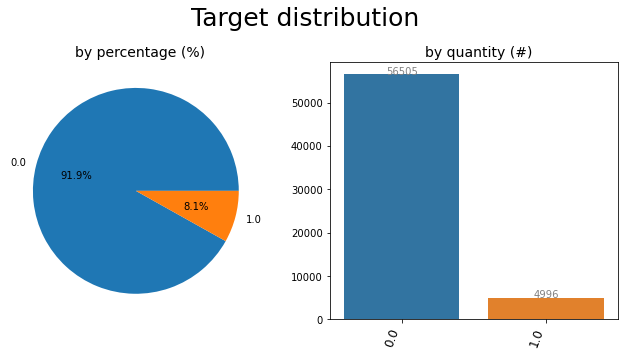

In [9]:
barplot_and_pie(df_copy["TARGET"], "Target distribution", " ")

In [10]:
df_analysis(df_copy, "df", analysis_type="header")


Analysis Header of df dataset
--------------------------------------------------------------------------------
- Dataset shape:			 61501 rows and 509 columns
- Total of NaN values:			 0
- Percentage of NaN:			 0.0 %
- Total of infinite values:		 0
- Percentage of infinite values:	 0.0 %
- Total of full duplicates rows:	 0
- Total of empty rows:			 0
- Total of empty columns:		 0
- Unique indexes:			 True
- Memory usage:				 92.4 MB


<div class="alert alert-block alert-danger">
    <p><b>FLAG</b>
   </p>
</div>

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">5. Splitting data</h2>
</div>

<div class="alert alert-block alert-info">
    <p>First of all, let's identify the training columns in the dataset
   </p>
</div>

In [11]:
NOT_TRAINING_COLUMNS  = ["TARGET", "SK_ID_CURR", "SK_ID_BUREAU", "SK_ID_PREV", "index"] 
TRAINING_COLUMNS = [col for col in df_current_clients.columns if col not in NOT_TRAINING_COLUMNS]

<div class="alert alert-block alert-info">
    <p>Now, we are going to split the data
   </p>
</div>

In [12]:
X = df_current_clients[TRAINING_COLUMNS]

In [13]:
y_target = df_current_clients.loc[:,"TARGET"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

In [15]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (246005, 506)
y_train: (246005,)
---------------------
X_test: (61502, 506)
y_test: (61502,)


<div class="alert alert-block alert-danger">
    <p><b>FLAG</b>
   </p>
</div>

In [16]:
X = df_copy[TRAINING_COLUMNS]

In [17]:
y_target = df_copy.loc[:,"TARGET"]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y_target, test_size=0.20, stratify=y_target, random_state=42)

In [19]:
print("X_train: {}".format(X_train.shape))
print("y_train: {}".format(y_train.shape))
print("---------------------")
print("X_test: {}".format(X_test.shape))
print("y_test: {}".format(y_test.shape))

X_train: (49200, 506)
y_train: (49200,)
---------------------
X_test: (12301, 506)
y_test: (12301,)


<div class="alert alert-block alert-danger">
    <p><b>FLAG</b>
   </p>
</div>

In [20]:
ccc

NameError: name 'ccc' is not defined

<div style="background-color: #506AB9;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">6. Modelisation</h2>
</div>

<div class="alert alert-block alert-info">
    <p>We are going to face an <b>Unbalanced Classification Problem</b> and we are going to use three models</p>
    <ul style="list-style-type: square;">
        <li>Random Forest Classifier</li>
        <li>Support Vector Machine</li>
        <li>LightGBM</li>
    </ul>
    <p>Also, we are going to use a Cost Function to penalize the Falses Positives</p>
    <p>So, let's define the parameters to use throughout the three models</p>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.1. General parameters</h3>
</div>

<div class="alert alert-block alert-info">
    <p>To treat the unbalanced class, we are going t implement OverSampling technique with SMOTE.</p>
</div>

In [ ]:
smote = SMOTE(random_state=42, n_jobs=-1)

<div class="alert alert-block alert-info">
    <p>Also, we are going to use Stratified K-Folds cross-validator to ensure that each fold of dataset has the same proportion of observations with a given label.</p>
</div>

In [21]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

<div class="alert alert-block alert-info">
    <p>Dataframe to compare metrics.</p>
</div>

In [ ]:
df_models_metrics = pd.DataFrame({})

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Hyperparameters Tuning</h3>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2.1. Random Forest</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "n_estimators" : np.arange(500, 1000, 100),
    "max_depth" : np.arange(20, 30, 2),
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
clf_rf = RandomForestClassifier(random_state=42)

In [ ]:
search_clf = HalvingGridSearchCV(clf_rf, param_grid, cv=stratified_kfold, n_jobs=-1)

In [ ]:
search_clf.fit(X_train, y_train)

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [ ]:
search_clf.best_score_

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [ ]:
search_clf.best_params_

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2.2. LightGBM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "n_estimators" : [8000, 10000],
    "num_leaves" : [32, 34], 
    "max_depth" : [8, 9]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
clf_lgbm = LGBMClassifier(random_state=42)

In [ ]:
search_lgbm = HalvingGridSearchCV(clf_lgbm, param_grid, cv=stratified_kfold, n_jobs=-1)

In [ ]:
search_lgbm.fit(X_train, y_train)

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [ ]:
search_lgbm.best_score_

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [ ]:
search_lgbm.best_params_

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2.3. Gradient Boosting</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [25]:
param_grid = {
    "n_estimators" : np.arange(500, 1000, 100),
    "max_depth" : np.arange(20, 30, 2),
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [26]:
clf_gb = GradientBoostingClassifier(random_state=42)

In [27]:
search_gb = HalvingGridSearchCV(clf_gb, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [28]:
search_gb.fit(X_train, y_train)

KeyboardInterrupt: 

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "gamma" : ["scale", "auto"],
    "nu" : [0.4, 0.5, 0.6]
}

In [ ]:
clf_ocsvm.get_params().keys()

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
clf_ocsvm = OneClassSVM()

In [ ]:
search_ocsvm = HalvingGridSearchCV(clf_ocsvm, param_grid, scoring="roc_auc", cv=stratified_kfold, n_jobs=-1)

In [ ]:
search_ocsvm.fit(X_train, y_train)

<div class="alert alert-block alert-info">
    <p>ROC-AUC score</p>
</div>

In [ ]:
search_ocsvm.best_score_

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [ ]:
search_ocsvm.best_params_

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [ ]:
clf_ocsvm = imbpipeline(steps = [["Smote", smote],
                              ["OneClassSVM", OneClassSVM()]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "OneClassSVM__gamma" : ["scale", "auto"],
    "OneClassSVM__nu" : [0.4, 0.5, 0.6]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
search_ocsvm = GridSearchCV(estimator=clf_ocsvm,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [ ]:
search_ocsvm.fit(X_train, y_train)

In [ ]:
ZZZZZZZZZZZZZZZZZZZZ

<div style="background-color: red;" >
    <h2 style="margin: auto; padding: 20px; color:#fff; ">----------- FLAG -----------</h2>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1.2. Threshols selection</h4>
</div>

In [ ]:
def threshold_selection(y_train, y_prob):
    """
    Method used to calculate the threshold.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        y_train (1d array-like): True values
        y_prob (1d array-like): Probabilite values predicted
        
    Returns:
    -----------------
        threshold (float) : Best threshold value
        Threshold (image) : Plot the threshold and the best score
    """
    
    scores = []
    
    for threshold in np.linspace(0, 1, num=101):
        y_prob_value = (y_prob > threshold)*1
        score = fbeta_score(y_train, y_prob_value, beta = 2)
        scores.append(score) 

    scores = np.asarray(scores)
    best_threshold, best_score = (scores.argmax()*.01, round(scores.max(),3))
    
    print("Best results")
    print("- Best Threshold:\t", best_threshold)
    print("- Best Score:\t\t", best_score)
    print("\n")
    
    plt.subplots(1, figsize=(6, 5))
    plt.plot(np.linspace(0, 1, num=101), scores, lw=1)
    plt.axvline(best_threshold, ls="--", lw=1, c="r")
    plt.title("Threshold")
    plt.xlabel("proba threshold")
    plt.ylabel("Score performed")
    plt.show()
    
    return best_threshold

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.1.3. Custom Score</h4>
</div>

<div class="alert alert-block alert-info">
    <p>We need to penalize the <b>False Negative</b> that are loands <b>will be in default</b>, and they were <b>predicted incorrectly</b>. Due to that, we are going to define a <b>Custom Score</b>.
    </p>
</div>

In [ ]:
def custom_score(y_true, y_pred, threshold):
    """
    Method used to calculate a score based on the penalization of False Negatives.

    Parameters:
    -----------------
        y_true (series): True values
        y_pred (series): Predicted values
        threshold (float): Threshold value to use
        
    Returns:
    -----------------
        Score. (float): Score obtained based on the rules defined to measure. 
    """
    
    # Getting the probability outputs from "predict_proba"
    y_pred = (y_pred > threshold).astype(int)
    
    TN_rate = 1        # Loans that are not in default and were predicted correctly
    TP_rate = 1        # Loans that are in default and were predicted correctly
    FP_rate = 0        # Loans that are not in default and were predicted incorrectly
    FN_rate = -100      # Loans that are in default and were were predicted incorrectly
    
    # Getting all values based on confusion matrix
    (TN, FP, FN, TP) = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Total of default and not default cases
    total_not_default = TN + FP     # Not default cases
    total_default = TP + FN         # Default cases 
    
    gain_total = TN*TN_rate + TP*TP_rate + FP*FP_rate + FN*FN_rate
    gain_maximun = total_not_default*TN_rate + total_default*TP_rate
    gain_minumun = total_not_default*TN_rate + total_default*FN_rate
    
    # normalize to get score between 0 (baseline) and 1
    score = (gain_total - gain_minumun) / (gain_maximun - gain_minumun)
    
    return score

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">6.2. Models</h3>
</div>

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2.1. Random Forest</h4>
</div>

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
clf_rf = imbpipeline(steps = [["Smote", smote],
                              ["Random_Forest", RandomForestClassifier(n_estimators=2000, 
                                                                       max_depth=45,
                                                                       random_state=42,
                                                                       n_jobs=-1)]
                          ]
                 )

In [ ]:
# Get the score for each validation score method to get accuracy of model
score = cross_val_score(clf_rf, X_train, y_train, cv=stratified_kfold, scoring="roc_auc")

In [ ]:
score

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [ ]:
clf_rf = imbpipeline(steps = [["Smote", smote],
                              ["Random_Forest", RandomForestClassifier(random_state=42,
                                                                       n_jobs=-1, verbose=2)]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "Random_Forest__n_estimators" : [1000], # 3000, 4000
    "Random_Forest__max_depth" : [45],#, 48 23, 24, 27
}

param_grid = {
    "Random_Forest__n_estimators" : [400, 450, 500, 2000, 3000, 4000],
    "Random_Forest__max_depth" : [23, 24, 27, 45, 48, 50],
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
search_rf = GridSearchCV(estimator=clf_rf,
                         param_grid=param_grid,
                         scoring="roc_auc",
                         cv=stratified_kfold,
                         return_train_score=True)

In [ ]:
search_rf.fit(X_train, y_train)

<div class="alert alert-block alert-info">
    <p>The best parameters</p>
</div>

In [ ]:
search_rf.best_params_

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [ ]:
model_rf = search_rf.best_estimator_

In [ ]:
y_pred = model_rf.predict(X_test)
y_prob = model_rf.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

In [ ]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [ ]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [ ]:
precision = round(precision_score(y_test, y_pred), 3)
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
f2 = round(fbeta_score(y_test, y_pred, beta=2), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

# Get the results
print("Model's metrics")
print("- Precision:\t\t", precision)
print("- ROC-AUC:\t\t", roc_auc)
print("- Recall:\t\t", recall)
print("- F1:\t\t\t", f1)
print("- F2:\t\t\t", f2)
print("- Custom Score:\t\t", custom)
print("- Duration:\t\t", round(search_rf.cv_results_["mean_score_time"][0], 3), " minutes")

<div class="alert alert-block alert-danger">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>XXXXXXXXXXXXXXXXXXXXXXXX</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

In [ ]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="RandomForestClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Adding metrics to compare with others models</p>
</div>

In [ ]:
df_temp = pd.DataFrame({
    "Model" : ["Random Forest"],
    "Precision" : precision, 
    "ROC-AUC" : roc_auc,    
    "Recall" : recall,
    "F1" : f1,
    "F2" : f2,
    "Custom" : custom,
    "Duration" : round(search_rf.cv_results_["mean_score_time"][0], 3)
})

In [ ]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics

In [ ]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics

In [ ]:
x

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2.2. One-Class SVM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
</div>

In [ ]:
clf_ocsvm = imbpipeline(steps = [["Smote", smote],
                              ["OneClassSVM", OneClassSVM()]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "OneClassSVM__gamma" : ["scale", "auto"],
    "OneClassSVM__nu" : [0.4, 0.5, 0.6]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
search_ocsvm = GridSearchCV(estimator=clf_ocsvm,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [ ]:
search_ocsvm.fit(X_train, y_train)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [ ]:
model_ocsvm = search_ocsvm.best_estimator_

In [ ]:
y_pred = model_ocsvm.predict(X_test)
y_prob = model_ocsvm.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

In [ ]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [ ]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [ ]:
precision = round(precision_score(y_test, y_pred), 3)
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
f2 = round(fbeta_score(y_test, y_pred, beta=2), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

# Get the results
print("Model's metrics")
print("- Precision:\t\t", precision)
print("- ROC-AUC:\t\t", roc_auc)
print("- Recall:\t\t", recall)
print("- F1:\t\t\t", f1)
print("- F2:\t\t\t", f2)
print("- Custom Score:\t\t", custom)
print("- Duration:\t\t", round(search_lgbm.cv_results_["mean_score_time"][0], 3), " minutes")

<div class="alert alert-block alert-danger">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>XXXXXXXXXXXXXXXXXXXXXXXX</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

In [ ]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="LGBMClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Adding metrics to compare with others models</p>
</div>

In [ ]:
df_temp = pd.DataFrame({
    "Model" : ["Random Forest"],
    "Precision" : precision, 
    "ROC-AUC" : roc_auc,    
    "Recall" : recall,
    "F1" : f1,
    "F2" : f2,
    "Custom" : custom,
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [ ]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics

<div style="background-color: #506AB9;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">6.2.3. LightGBM</h4>
</div>

<div class="alert alert-block alert-info">
    <p>Let's define the pipeline to put inside it the defined SMOTE</p>
    <p>We are going to use most of parameters used in the kernel selected</p>
</div>

In [ ]:
clf_lgbm = imbpipeline(steps = [["Smote", smote],
                                ["LightGBM", LGBMClassifier(metric="None",
                                                            learning_rate=0.02,
                                                            colsample_bytree=0.9497036,
                                                            subsample=0.8715623,
                                                            reg_alpha=0.041545473,
                                                            reg_lambda=0.0735294,
                                                            min_split_gain=0.0222415,
                                                            min_child_weight=39.3259775,
                                                            n_jobs=-1)]
                          ]
                 )

<div class="alert alert-block alert-info">
    <p>Parameters settings</p>
</div>

In [ ]:
param_grid = {
    "LightGBM__n_estimators" : [8000, 10000],
    "LightGBM__num_leaves" : [32, 34], 
    "LightGBM__max_depth" : [8, 9]
}

<div class="alert alert-block alert-info">
    <p>Executing the model</p>
</div>

In [ ]:
search_lgbm = GridSearchCV(estimator=clf_lgbm,
                           param_grid=param_grid,
                           scoring="roc_auc",
                           cv=stratified_kfold,
                           n_jobs=-1,
                           return_train_score=True)

In [ ]:
search_lgbm.fit(X_train, y_train)

<div class="alert alert-block alert-info">
    <p>Making predictions and probabilities based on the best results for the model</p>
</div>

In [ ]:
model_lgbm = search_lgbm.best_estimator_

In [ ]:
y_pred = model_lgbm.predict(X_test)
y_prob = model_lgbm.predict_proba(X_test)
y_prob = y_prob[:, 1]

<div class="alert alert-block alert-info">
    <p>Let's selet the threshold based on the best parameters</p>
</div>

In [ ]:
threshold = threshold_selection(y_test, y_prob)

<div class="alert alert-block alert-info">
    <p>Getting the probability outputs from "predict_proba" based on the threshold</p>
</div>

In [ ]:
y_pred = (y_pred > threshold).astype(int)

<div class="alert alert-block alert-info">
    <p>Now, we can get the metrics</p>
</div>

In [ ]:
precision = round(precision_score(y_test, y_pred), 3)
roc_auc = round(roc_auc_score(y_test, y_prob), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
f2 = round(fbeta_score(y_test, y_pred, beta=2), 3)
custom = round(custom_score(y_test, y_pred, threshold), 3)

# Get the results
print("Model's metrics")
print("- Precision:\t\t", precision)
print("- ROC-AUC:\t\t", roc_auc)
print("- Recall:\t\t", recall)
print("- F1:\t\t\t", f1)
print("- F2:\t\t\t", f2)
print("- Custom Score:\t\t", custom)
print("- Duration:\t\t", round(search_lgbm.cv_results_["mean_score_time"][0], 3), " minutes")

<div class="alert alert-block alert-danger">
    <p><b>Observations / Conclusions</b></p>
    <ul style="list-style-type: square;">
        <li>XXXXXXXXXXXXXXXXXXXXXXXX</li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    <p>Plotting the Compute ROC curve and ROC area for each class</p>
</div>

In [ ]:
fpr = dict()
tpr = dict()
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())

plt.subplots(1, figsize=(6, 6))
plt.title("Receiver Operating Characteristic")
plt.plot(fpr["micro"], tpr["micro"])
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

<div class="alert alert-block alert-info">
    <p>Plotting the Precision-Recall curve</p>
</div>

In [ ]:
display = PrecisionRecallDisplay.from_predictions(y_test.ravel(), y_prob.ravel(), name="LGBMClassifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

<div class="alert alert-block alert-info">
    <p>Plotting the Confusion Matrix</p>
</div>

In [ ]:
display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Repaid","No repaid"])
_ = display.ax_.set_title("Confusion matrix")

<div class="alert alert-block alert-info">
    <p>Adding metrics to compare with others models</p>
</div>

In [ ]:
df_temp = pd.DataFrame({
    "Model" : ["Random Forest"],
    "Precision" : precision, 
    "ROC-AUC" : roc_auc,    
    "Recall" : recall,
    "F1" : f1,
    "F2" : f2,
    "Custom" : custom,
    "Duration" : round(df_results.iloc[search.best_index_]["mean_score_time"], 3)
})

In [ ]:
df_models_metrics = pd.concat([df_models_metrics, df_temp])
df_models_metrics